In [31]:
from fastai.vision.all import *

In [32]:
path = Path.cwd()/'../datasets/Tomato_leaf'

In [33]:
tomato_leaf = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    item_tfms=Resize(400),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.3, seed=42)
)

In [34]:
dls = tomato_leaf.dataloaders(path)

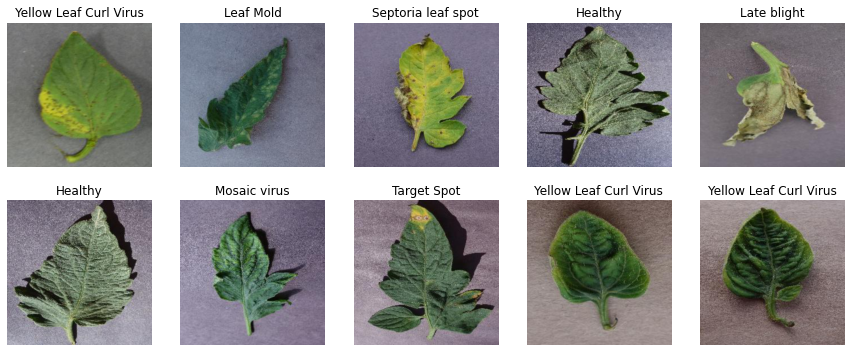

In [35]:
dls.train.show_batch(max_n=10, nrows=2)

In [36]:
model = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

In [ ]:
model.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.476153,0.170146,0.058370,0.941630,05:06


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.130431,0.058378,0.018722,0.981278,06:50
1,0.050421,0.060729,0.019824,0.980176,06:50
2,0.051940,0.115938,0.029736,0.970264,06:51
3,0.055582,0.052002,0.016520,0.983480,06:51
4,0.037268,0.076360,0.022026,0.977974,06:50
5,0.039719,0.049345,0.014317,0.985683,06:50
6,0.020819,0.056036,0.016153,0.983847,06:51
7,0.025289,0.034132,0.010279,0.989721,06:50
8,0.014091,0.020133,0.006057,0.993943,06:50
9,0.010450,0.026399,0.007709,0.992291,06:50


In [25]:
interp = ClassificationInterpretation.from_learner(model)

TypeError: plot_top_losses() missing 1 required positional argument: 'k'

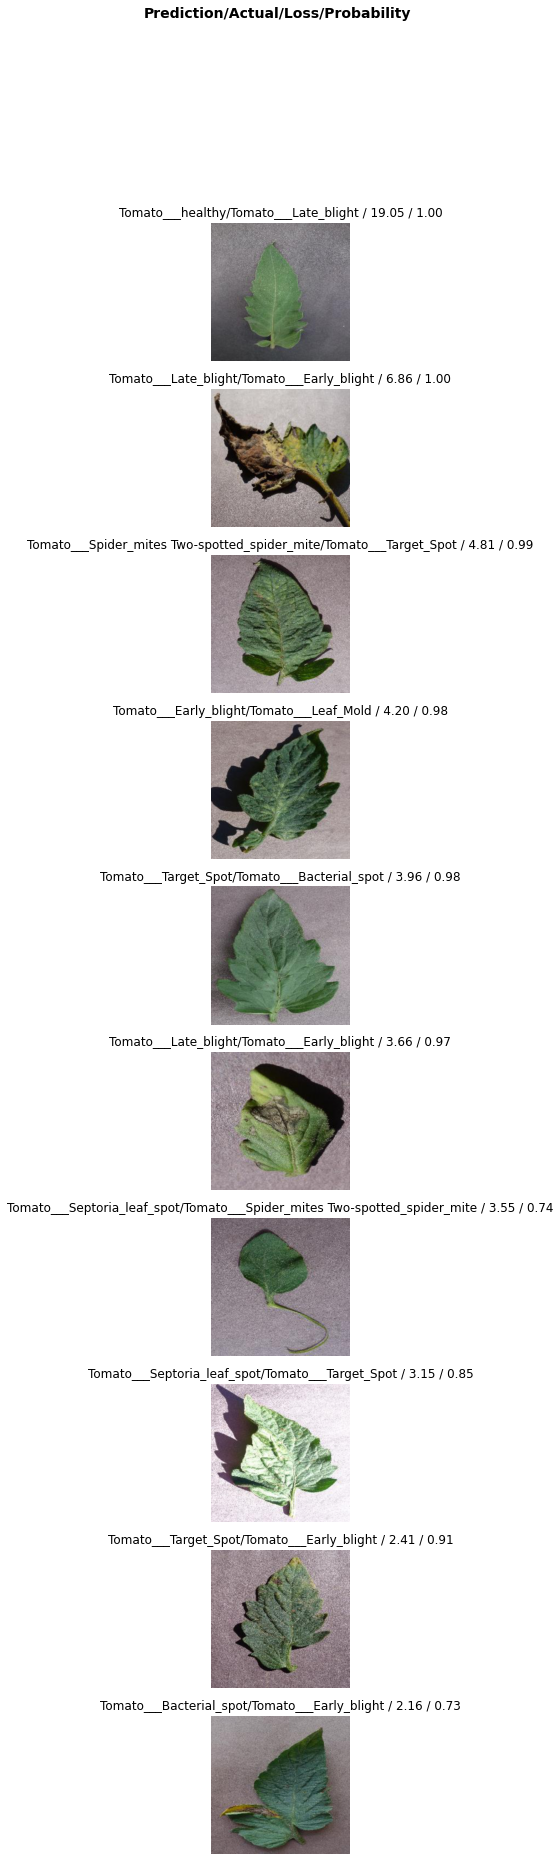

In [28]:
interp.plot_top_losses(10, nrows = 10)

In [52]:
import pandas as pd

col = model.dls.vocab
col = [i[9:] for i in col]

In [57]:
df = pd.DataFrame(interp.confusion_matrix(), columns=col)
df.style.set_properties().background_gradient('BuPu_r')

,Bacterial_spot,Early_blight,Late_blight,Leaf_Mold,Septoria_leaf_spot,Spider_mites Two-spotted_spider_mite,Target_Spot,Tomato_Yellow_Leaf_Curl_Virus,Tomato_mosaic_virus,healthy
0,626,0,0,0,0,0,1,0,0,0
1,3,284,6,0,0,0,3,0,0,0
2,0,0,569,1,0,0,0,0,0,1
3,0,1,0,290,0,0,0,0,0,0
4,1,0,0,0,557,0,0,0,0,0
5,0,1,0,0,1,506,0,0,0,0
6,0,1,0,0,2,1,407,0,0,0
7,0,0,0,0,0,1,0,1582,0,0
8,0,0,0,0,0,0,0,0,117,0
9,0,0,0,0,0,0,0,0,0,486


In [66]:
path = Path.cwd()/'../models/tomato.pkl'
model.export(path)

In [88]:
from fastai.vision.widgets import FileUpload, ImageClassifierCleaner
btn_upload = FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [93]:
model.predict(btn_upload.data[0])

('Tomato___Tomato_mosaic_virus',
 tensor(8),
 tensor([4.1341e-12, 1.7080e-08, 5.9448e-12, 1.5380e-08, 1.1095e-08, 7.6625e-07,
         3.0308e-10, 2.4193e-06, 1.0000e+00, 1.2450e-09]))

In [79]:
model.dls.vocab

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']